# This notebook is not only prepared for the competition, but for those who want to improve themselves in this field in the long run:))...

# The more you vote the more features i will add :))...
# The more you vote the more features i will add :))...
# The more you vote the more features i will add :))...

# **1 Pct_change**

# **2 Volatility**

# **3 Moving Average ( SMA, EMA, WMA) with Trading Strategy**

# **4 MACD (Moving Average Convergence Divergence) with Trading Strategy**

# **5 RSI (The Relative Strength Index) with Trading Strategy**

# Technical Features & Trading Strategy

## İmport and get adjusted close

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
from decimal import ROUND_HALF_UP, Decimal
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [ ]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    price.set_index("Date", inplace=True)
    return price

In [ ]:
df_Price = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")

In [ ]:
df_Price = adjust_price(df_Price)

In [ ]:
df_Price = df_Price.loc[df_Price["SecuritiesCode"] == 9990].copy()
col = "AdjustedClose"

In [ ]:

df_Price = df_Price.replace("－", np.nan)
df_Price = df_Price.fillna(method='ffill')
df_Price = df_Price.fillna(method='bfill')
df_Price.isnull().sum().sum()

In [ ]:
df_Price = df_Price.filter(["Date", "SecuritiesCode", "Open","High","Low","Volume","Close","AdjustedClose"])

In [ ]:
df_Price = df_Price.loc[df_Price["SecuritiesCode"] == 9990].copy()

In [ ]:
col = "AdjustedClose"

In [ ]:
plt.figure(figsize=(16,8))
plt.title("Close Price History for 7203",fontsize=18)
plt.plot(df_Price[col])
plt.xlabel("Date",fontsize=18)
plt.ylabel("AdjustedClose")
plt.show()

## PCT_CHANGE

**Formula**

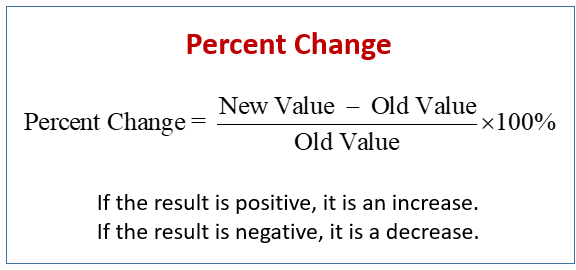

* The pct_change() is a function in Pandas that calculates the percentage change between the elements from its previous row by default. In the case of time series data, this function is frequently
* By default, periods=1, which means that the value in the previous row will be used to compute the percentage change.
* If periods=2, then the percentage change will be computed using the values of two rows back.
* link: https://www.alphacodingskills.com/pandas/notes/pandas-function-dataframe-pct-change.php

* Another way to fill the missing values is to use the forward fill using fill_mehtod=”ffill”
* ```
df_Price[col].pct_change(fill_method="ffill")
df_Price[col].pct_change(fill_method="bfill")
```

In [ ]:
periods = [10, 21, 63]
for period in periods:
    df_Price.loc[:, f"pct_change{period}"] = df_Price[col].pct_change(period)

In [ ]:
df_Price.iloc[:,7:10].tail()

In [ ]:
location = df_Price.iloc[:,7:10]
plt.figure(figsize=(20,8))
plt.title("pct_change for 7203",fontsize=28)
plt.plot(location)
plt.xlabel("Date",fontsize=28)
plt.ylabel("price",fontsize=28)
plt.legend(location.columns)
plt.show()

## Volatility

**What Is Volatility?**

* Volatility is a statistical measure of the dispersion of returns for a given security or market index. In most cases, the higher the volatility, the riskier the security.

* Volatility often refers to the amount of uncertainty or risk related to the size of changes in a security's value. A higher volatility means that a security's value can potentially be spread out over a larger range of values. This means that the price of the security can change dramatically over a short time period in either direction. A lower volatility means that a security's value does not fluctuate dramatically, and tends to be more steady

* Volatility is often measured as either the standard deviation or variance between returns from that same security or market index.

**Key Takeaways**
* Volatility represents how large an asset's prices swing around the mean price—it is a statistical measure of its dispersion of returns.
* There are several ways to measure volatility, including **beta coefficients, option pricing models, and standard deviations of returns.**
* Volatile assets are often considered riskier than less volatile assets because the price is expected to be less predictable.
* Volatility is an important variable for calculating options prices.

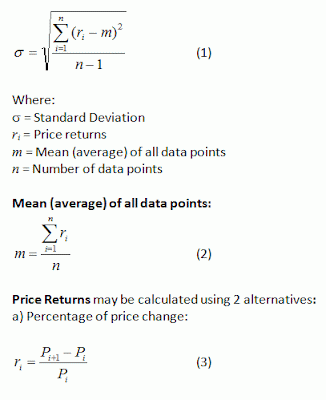

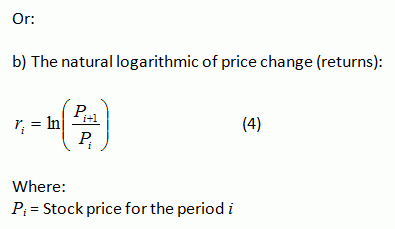

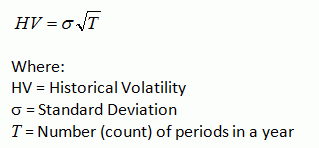

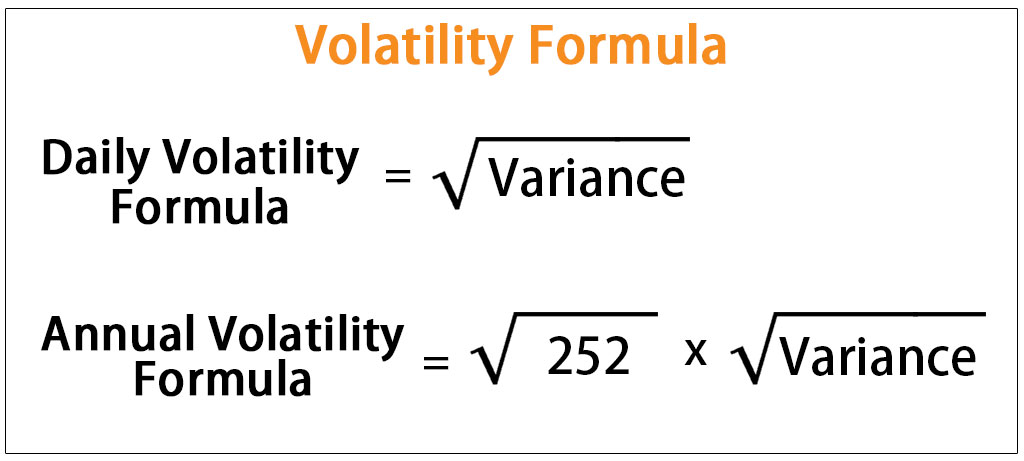

**Links**
* https://www.learnpythonwithrune.org/calculate-the-volatility-of-historic-stock-prices-with-pandas-and-python/
* https://www.learnpythonwithrune.org/start-python-with-pandas-for-financial-analysis/
* http://best-tradingguide.blogspot.com/2010/11/historical-volatility-part-2-formula-to.html

**Daily volatility**

In [ ]:
## np.log(df_Price[col]/df_Price[col].shift()).std() <= same formula

volatility_daily =np.log(df_Price[col]).diff().std()
volatility_daily

**Annual volatility**

In [ ]:
volatility_annual = np.log(df_Price[col]).diff().std()*252**.5
volatility_annual

In [ ]:
str_vol = str(round(volatility_annual, 4)*100)
fig, ax = plt.subplots()
np.log(df_Price[col]).diff().hist(ax=ax, bins=50, alpha=0.6, color="b")
ax.set_xlabel("Log return")
ax.set_ylabel("Freq of log return")
ax.set_title("SC:7203 volatility: " + str_vol + "%")

**Volatility for various periods**

In [ ]:
periods = [10, 21, 63]

for period in periods:
    df_Price.loc[:, f"volatility_{period}"] = np.log(df_Price[col]).diff().rolling(period).std()

In [ ]:
location = df_Price.iloc[:,10:13]
plt.figure(figsize=(20,8))
plt.title("Volatility for 7203",fontsize=28)
plt.plot(location)
plt.xlabel("Date",fontsize=28)
plt.ylabel("price",fontsize=28)
plt.legend(location.columns)
plt.show()

## Moving Average (SMA,EMA,WMA)

* The term “moving average” refers to the technical analysis technique that smoothens the fluctuation observed in the data in order to draw insights about any available trend or pattern in the data
* A Moving Average is used to analyze the time-series data by calculating averages of different subsets of the complete dataset. Moving Average is also known as Rolling or Running Average.

* It is also known as Rolling Mean or Moving Mean because it includes taking the average of the dataset. Moving average is mostly used with time-series data to capture the short-term fluctuations while focusing on longer trends. It smoothens the data.

**Types**
* Simple Moving Average
* Weighted Moving Average
* Exponential Moving Average

**Formula**

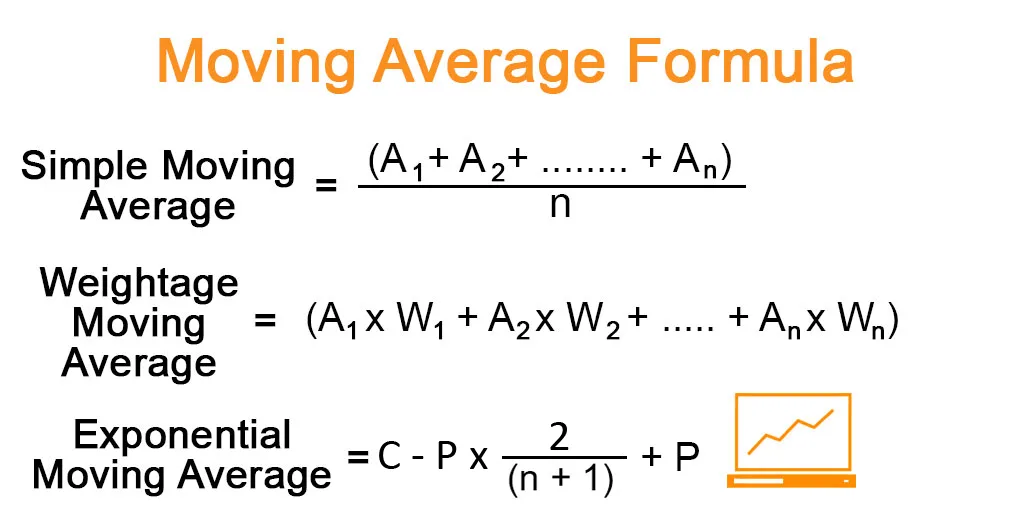

**links:**
* https://www.educba.com/moving-average-formula/
* https://quantstrategies.academy/2020/08/28/how-to-use-moving-average/
* https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/
* https://www.youtube.com/watch?v=cwEORaERl2o&list=PL9ATnizYJ7f9pCPBzr-isv0_R3E6OW6YY&index=17

**Calculation of MA**

Simple Moving Average = (A1 + A2 + …… + An) / n

* Step 1: Firstly, decide on the number of the period for the moving average, such as 2-day moving average, 5-day moving average, etc.
* Step 2: Next, simply add the selected number of consecutive data points and divide by the number of periods. Repeat the exercise to arrive at a set of averages.

* In this example, I choose periods -> every 3 months and get mean of them. You will only get 10 values; (12-3+1)

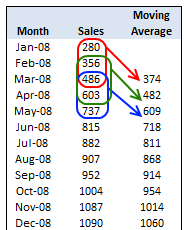

**Calculation of WMA**

Weightage Moving Average = (A1*W1 + A2*W2 + …… + An*Wn)

* Step 1: Firstly, decide on the weightage to be assigned to the data point of each period.

* Step 2: Next, add the products of the data points and their respective weightage. Repeat the exercise to arrive at a set of averages.

**Calculation of EMA**

Exponential Moving Average = (C – P) * 2 / (n + 1) + P

* Step 1: Firstly, decide on the number of the period for the moving average. Then calculate the multiplying factor based on the number of periods i.e. 2 / (n + 1).

* Step 2: Next, deduct the exponential moving average of the previous period from the current data point and then multiplied by the factor. Then add back the exponential moving average of the previous period. Repeat the exercise to arrive at a set of averages.

**Popular time periods**

* The most popular time periods used in Moving Averages are 10, 15, 20, 30, 50, 100, and 200 bars. These can be minutes, hours, or days according to the time-frame selected.

* Day Traders usually prefer to use short-term MAs like 10, 20, or 50. Swing Traders look a longer time-frames and usually focus their analysis on 20, 50, 100, and 200 Moving Averages.

### **SMA**

* When you add an MA on the chart, it helps you get a clear picture of the direction of the trend by smoothing out the sporadic price movements.

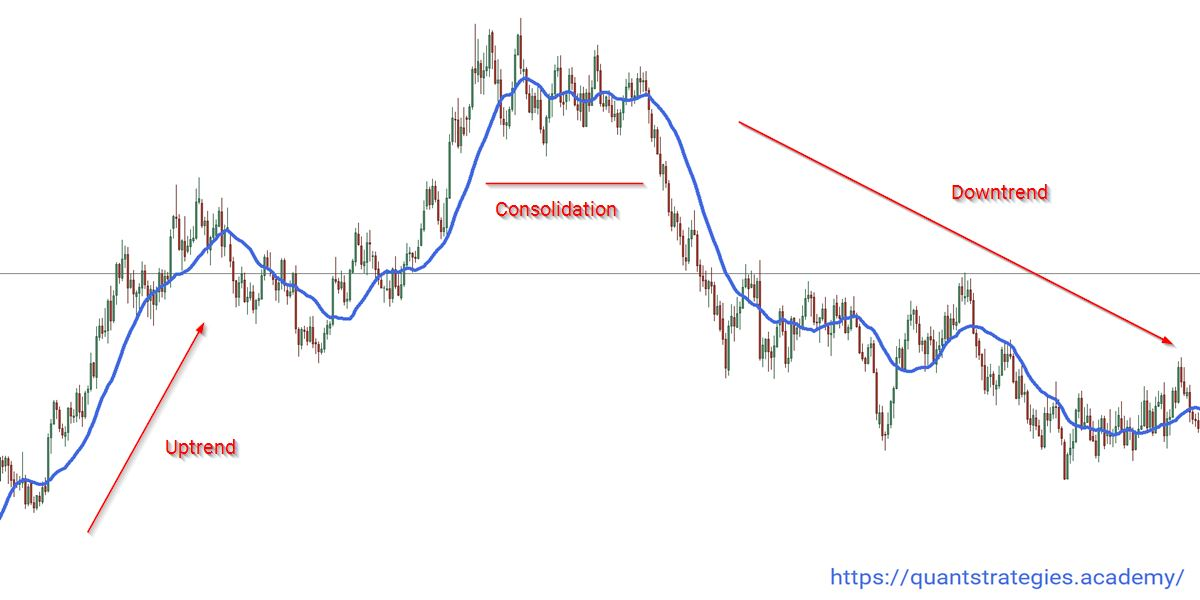

In [ ]:
periods = [10, 15, 20, 30, 50, 100, 200]
# Calculating the short-window simple moving average
for period in periods:
    df_Price.loc[:, f"MA_{period}"] = df_Price[col].rolling(window=period).mean()

In [ ]:
liste = list(df_Price.iloc[:,13:20].columns) + [col]

plt.figure(figsize=(20,8))
plt.title("MA for 7203",fontsize=18)
plt.plot(df_Price[liste])
plt.xlabel("Date",fontsize=18)
plt.ylabel("MA")
plt.legend(liste)
plt.show()

### **Trading Strategy with MA**

* Get Buy and Sell Signals

In [ ]:
df_trad = df_Price.copy()
df_trad["Signal"] = np.where(df_trad["MA_20"] > df_trad["MA_50"],1,0)
df_trad["Position"] = df_trad["Signal"].diff()
df_trad["Buy"] = np.where(df_trad["Position"] == 1, df_trad[col], np.NaN)
df_trad["Sell"] = np.where(df_trad["Position"] == -1, df_trad[col], np.NaN)

In [ ]:
# Visually show the close price with the MAs and Buy & Sell signals
plt.figure(figsize=(20,8))
plt.title("Close Price History w/ Buy & Sell Signals",fontsize=28)
plt.plot(df_trad[col], alpha = 0.5, label ="Close", color ="brown")
plt.plot(df_trad["MA_20"], alpha = 0.5, label ="MA_20")
plt.plot(df_trad["MA_50"], alpha = 0.5, label ="MA_50")

plt.scatter(df_trad.index, df_trad["Buy"], alpha = 1, label = "Buy Signal", marker = "^", color ="green", )
plt.scatter(df_trad.index, df_trad["Sell"], alpha = 1, label = "Sell Signal", marker = "v", color ="red")
plt.xlabel("Date",fontsize=28)
plt.ylabel(col)
plt.legend([col,'MA_20','MA_50'])
plt.show()

**For example:**

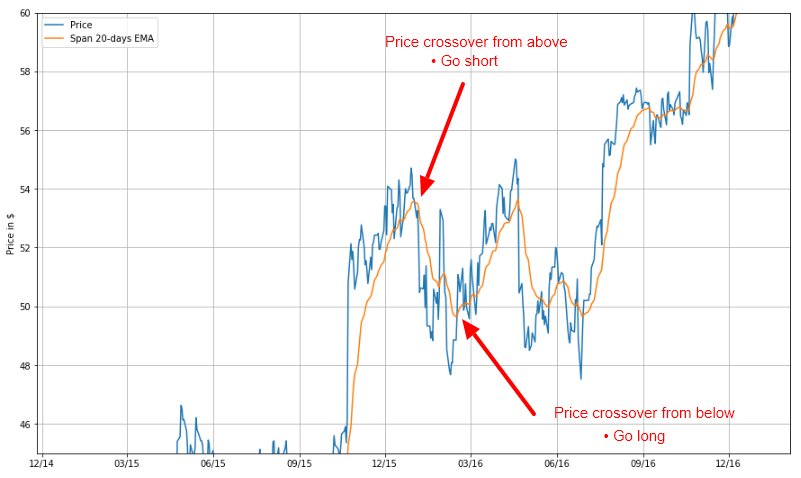

### **EMA**

**One way to reduce the lag** induced by the use of the SMA is to use the so-called Exponential Moving Average (EMA)

In [ ]:
periods = [10, 15, 20, 30, 50, 100, 200]
# Using Pandas to calculate a 20-days span EMA. adjust=False specifies that we are interested in the recursive calculation mode.
for period in periods:
    df_Price.loc[:, f"EMA_{period}"] = df_Price[col].ewm(span=period, adjust=False).mean()

In [ ]:
df_Price.columns

In [ ]:
liste2 = list(df_Price.iloc[:,20:27].columns) + [col]

plt.figure(figsize=(20,8))
plt.title("EMA for 7203",fontsize=28)
plt.plot(df_Price[liste2])
plt.xlabel("Date",fontsize=28)
plt.ylabel("EMA")
plt.legend(liste2)
plt.show()

**WMA**

In [ ]:
periods = [10, 15, 20, 30, 50, 100, 200]

for period in periods:
     weights = np.arange(1, period + 1)
     df_Price.loc[:, f"WMA_{period}"] =  wmas = df_Price[col].rolling(period).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True).to_list()


In [ ]:
liste3 = list(df_Price.iloc[:,27:34].columns) + [col]

plt.figure(figsize=(20,8))
plt.title("WMA for 7203",fontsize=28)
plt.plot(df_Price[liste3])
plt.xlabel("Date",fontsize=28)
plt.ylabel("WMA")
plt.legend(liste3)
plt.show()

## MACD

* Moving average convergence divergence (MACD) is a **trend-following momentum indicator** that shows the relationship between two moving averages of a security’s price. 
* The MACD is calculated **by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA.**

**Key Takeaways**
* MACD triggers technical signals when it **crosses above (to buy) or below (to sell)** its signal line.
* The speed of crossovers is also taken as a signal of a market is **overbought or oversold.**
* MACD helps investors understand whether the **bullish or bearish movement** in the price is **strengthening or weakening**.
* A MACD positive divergence is a situation in which the MACD does not reach a new low, despite the fact that the price of the stock reached a new low. This is seen as a bullish trading signal—hence, the term “positive divergence.” If the opposite scenario occurs—the stock price reaching a new high, but the MACD failing to do so—this would be seen as a bearish indicator and referred to as a negative divergence.

**Links:**
* https://www.investopedia.com/terms/m/macd.asp
* https://www.youtube.com/c/ComputerSciencecompsci112358/videos
* https://www.youtube.com/watch?v=jddmdKDq_VQ&list=PLvMRWNpDTNwQF6t_Tq7aVX0AI6H1avSpv&index=7 
* https://www.youtube.com/watch?v=kz_NJERCgm8&t=1630s
* https://www.youtube.com/watch?v=JzdVPnCSSuo

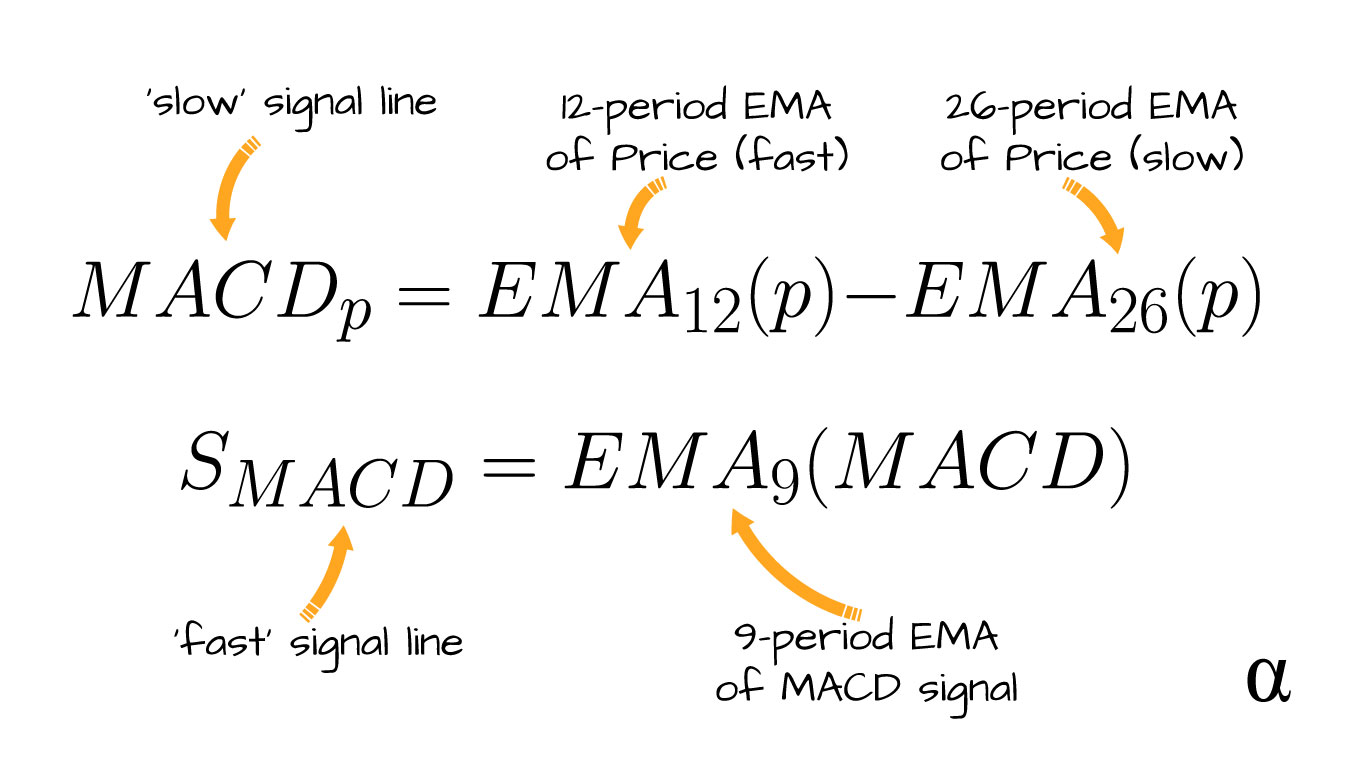

**For example:**

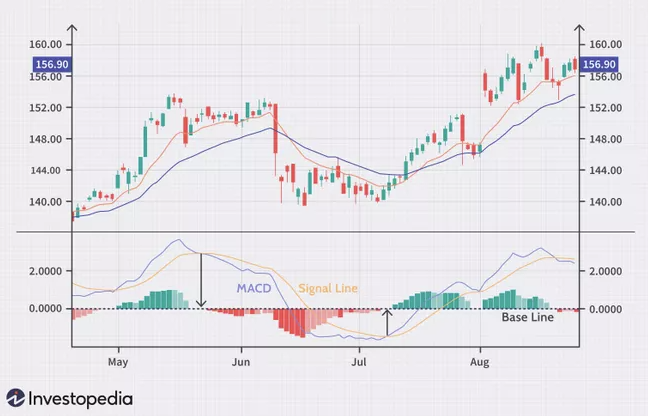

**Calculation**

* MACD = 12 period EMA - 26 Period EMA
* Signal line = 9 period EMA of MACD

In [ ]:
exp1 = df_Price[col].ewm(span=12, adjust=False).mean()
exp2 = df_Price[col].ewm(span=26, adjust=False).mean()
df_Price["MACD"] = exp1 - exp2
df_Price["Signal_line"] = df_Price["MACD"].ewm(span=9, adjust=False).mean()

In [ ]:
plt.figure(figsize=(20,8))
plt.title("MACD and Signal_line for 7203",fontsize=28)
plt.plot(df_Price[["MACD","Signal_line"]])
plt.xlabel("Date",fontsize=28)
plt.ylabel("WMA")
plt.legend(["MACD", "Signal_line"])
plt.show()

### **Trading Strategy with MACD**

In [ ]:
Buy, Sell = [], []
for i in range(2,len(df_Price)):
    if df_Price.MACD.iloc[i] > df_Price.Signal_line.iloc[i] and df_Price.MACD.iloc[i-1] < df_Price.Signal_line.iloc[i-1]:
      Buy.append(i)
    elif df_Price.MACD.iloc[i] < df_Price.Signal_line.iloc[i] and df_Price.MACD.iloc[i-1] > df_Price.Signal_line.iloc[i-1]:
      Sell.append(i)

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Close price Buy & Sell Signals for 7203",fontsize=28)
plt.scatter(df_Price.iloc[Buy].index, df_Price.iloc[Buy].AdjustedClose, marker="^", color = "green")
plt.scatter(df_Price.iloc[Sell].index, df_Price.iloc[Sell].AdjustedClose, marker="v", color = "red")
plt.plot(df_Price[col],label="Close Price", alpha = 0.35,color = "brown")
plt.xlabel("Date",fontsize=28)
plt.ylabel("AdjustedClose")
plt.legend(loc = "upper left")
plt.show()

## RSI

* The Relative Strength Index (RSI) is a**momentum indicator** that describes **the current price relative to average high and low prices over a previous trading period**

* This indicator estimates **overbought or oversold status** and helps spot **trend reversals, price pullbacks, and the emergence of bullish or bearish markets.**

* The RSI can help signal lucrative **entry/exit timings** based on the current market dynamics. Combined with other momentum indicators like the Bollinger Bands and varying Moving Averages, the RSI serves as one of the most popular technical indicators used for systematic trading strategies. This article will introduce the RSI as a trading indicator and detail three ways it can be calculated using the Python programming language.

* The Relative Strength Index (RSI) is a momentum oscillator that conveys buying and selling pressure in a given market. When applied to a single stock, a low RSI value indicates oversold status and a high value indicates oversold. Values for overbought are usually between 70-80 and those reflecting oversold status between 20-30. These values can be adjusted based on trader preference.

* The RSI is a **momentum oscillator** (oscillator is a line graph that moves between two extremes).

* It is **scaled between 0 – 100**.

* When the RSI reading is **above 70** it usually considered **overbought** and when it falls **below 30** it usually considered **oversold**.

* The standard is to **use 14 periods** to calculate the initial RSI value, but you can choose the time frame you think fit the most.

**links**
* https://medium.com/codex/algorithmic-trading-with-relative-strength-index-in-python-d969cf22dd85
* https://www.youtube.com/watch?v=pB8eJwg7LJU&list=RDCMUC87aeHqMrlR6ED0w2SVi5nw&index=7
* https://www.youtube.com/watch?v=pB8eJwg7LJU&list=PL9ATnizYJ7f9pCPBzr-isv0_R3E6OW6YY&index=18

**Formula**

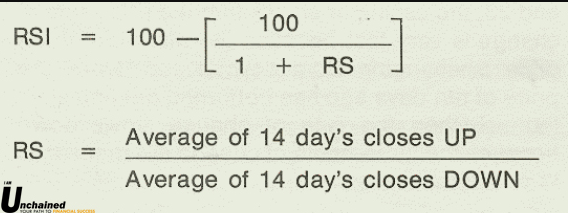

In [ ]:
def RSIcalc(df):

    df["MA_200"] = df[col].rolling(200).mean()
    df["pct_change1"] = df[col].pct_change()

    df["upmove"] = df["pct_change1"].apply(lambda x: x if x>0 else 0)
    df["downmove"] = df["pct_change1"].apply(lambda x: abs(x) if x<0 else 0)

    df["avgup"] = df["upmove"].ewm(span=14).mean()
    df["avgdown"] = df["downmove"].ewm(span=14).mean()
    #df = df.dropna()
    df["RS"] = df["avgup"]/df["avgdown"]
    df["RSI"] = df["RS"].apply(lambda x: 100-(100/(x+1)))

    #df.loc[(df[col] > df["MA_200"]) & (df["RSI"] < 30), "Buy"] = "Yes"
    #df.loc[(df[col] < df["MA_200"]) | (df["RSI"] > 30), "Sell"] = "No"
    return df
df_Price = RSIcalc(df_Price)

In [ ]:
location = df_Price[["RSI"]]
plt.figure(figsize=(20,8))
plt.title("RSI for 7203",fontsize=28)
plt.plot(location)
plt.xlabel("Date",fontsize=28)
plt.ylabel("price")
plt.legend(location.columns)
plt.show()

Trading

### Trading Strategy RSI

In [ ]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = implement_rsi_strategy(df_Price[col], df_Price['RSI'])

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(df_Price[col], linewidth = 2.5, color = 'skyblue', label = col)
plt.plot(df_Price.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
plt.plot(df_Price.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
plt.legend([col,"BUY SIGNAL",'SELL SIGNAL'])
plt.title("RSI TRADE SIGNALS",fontsize=28)
plt.plot(location)
plt.xlabel("Date",fontsize=28)
plt.ylabel("price")

In [ ]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(df_Price[col], linewidth = 2.5, color = 'skyblue', label = col)
ax1.plot(df_Price.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(df_Price.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('7209 RSI TRADE SIGNALS')
ax2.plot(df_Price["RSI"], color = 'orange', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

# The more you vote the more features i will add :))...
# The more you vote the more features i will add :))...
# The more you vote the more features i will add :))...